## Overview

Notebook workspace for PlaneSpotSlicer.

Prerequisites:

* install scvis using this package: https://github.com/shahcompbio/scvis

In [1]:
from typing import Union

import meerkat as mk
import numpy as np
import torch
import torch.optim as optim
from torch.nn.functional import cross_entropy
from tqdm import tqdm

from domino.utils import unpack_args

from abstract import Slicer
from sklearn import mixture

import glob

In [62]:
from typing import Union

import meerkat as mk
import numpy as np
import torch
import torch.optim as optim
from torch.nn.functional import cross_entropy
from tqdm import tqdm

from domino.utils import unpack_args

from abstract import Slicer

## PlaneSpot imports
from sklearn import mixture
import glob

from domino.utils import convert_to_numpy, unpack_args
import pandas as pd

class PlaneSpotSlicer(Slicer):
    r"""
    Implements PlaneSpot [plumb_2023], a simple SDM that fits a GMM to a 2D model 
    embedding, fit using scvis [ding_2018]. 

    ..  [plumb_2023]
        Gregory Plumb*, Nari Johnson*, Ángel Alexander Cabrera, Ameet Talwalkar.
        Towards a More Rigorous Science of Blindspot Discovery in Image 
        Classification Models. arXiv:2207.04104 [cs] (2023)
        
    ..  [ding_2018]
        Jiarui Ding, Anne Condon, and Sohrab P Shah. 
        Interpretable dimensionality reduction of single cell transcriptome 
        data with deep generative models. 
        Nature communications, 9(1):1–13. (2018)
    """

    def __init__(
        self,
        scvis_conda_env: str, # name of conda environment where scvis is installed
        n_slices: int = 10,
        n_max_mixture_components: int = 33, # maximum number of mixture components
        weight: float = 0.025, # weight hyperparameter
        scvis_config_path = None, # custom scvis config path
        scvis_output_dir = 'scvis', # path to output directory for scvis
        fit_scvis = True # flag to load rather than re-compute the scvis embedding 
    ):
        super().__init__(n_slices=n_slices)
        
        # scvis hyper-parameters
        self.scvis_conda_env = scvis_conda_env
        self.config.scvis_config_path = scvis_config_path
        self.config.scvis_output_dir = scvis_output_dir
        self.fit_scvis = fit_scvis
        
        # GMM hyper-parameters
        self.config.n_max_mixture_components = n_max_mixture_components
        self.config.weight = weight

        self.gmm = None

    def fit(
        self,
        data: Union[dict, mk.DataPanel] = None,
        embeddings: Union[str, np.ndarray] = "embedding",
        targets: Union[str, np.ndarray] = None,
        pred_probs: Union[str, np.ndarray] = None,
        losses: Union[str, np.ndarray] = None,
        verbose: bool = True,
        **kwargs
    ):
        embeddings, targets, pred_probs, losses = unpack_args(
            data, embeddings, targets, pred_probs, losses
        )
        
        embeddings, targets, pred_probs = convert_to_numpy(
            embeddings, targets, pred_probs
        )
        
        # 1.  Fit scvis.
        if verbose:
            print('Fitting scvis...')
        
        scvis_embeddings = self._fit_scvis(embeddings.reshape(embeddings.shape[0], embeddings.shape[1]))
        
        # 2.  Fit GMM.
        if verbose:
            print('Fitting GMM...')
            
        self._fit_gmm(scvis_embeddings,
                     pred_probs)

    def predict_proba(
        self,
        data: mk.DataPanel,
        scvis_embeddings: str, # scvis column name
        pred_probs: str, # predicted probabilities column name
    ) -> np.ndarray:
        
        # Append the scvis embedding and predicted probabilities; normalize
        X = self._combine_embedding(dp[scvis_embeddings], dp[pred_probs])
        return self.gmm.predict_proba(X)

    def predict(
        self,
        data: mk.DataPanel,
        embeddings: Union[str, np.ndarray] = "embedding",
        targets: Union[str, np.ndarray] = None,
        pred_probs: Union[str, np.ndarray] = None,
        losses: Union[str, np.ndarray] = None,
    ) -> np.ndarray:
        probs = self.predict_proba(
            data=data,
            embeddings=embeddings,
            targets=targets,
            pred_probs=pred_probs,
            losses=losses,
        )

        # TODO (Greg): check if this is the preferred way to get hard predictions from
        # probabilities
        return (probs > 0.5).astype(np.int32)
    
    def _load_scvis_embeddings(self) -> np.ndarray:
        ''' Load and return the scvis embeddings.
        '''
        ### Load and return the scvis embeddings
        search_string = f'{self.config.scvis_output_dir}/*.tsv'
        scvis_embedding_filepath = sorted(glob.glob(search_string), key = len)[0]
        return pd.read_csv(scvis_embedding_filepath, sep = '\t', index_col = 0).values
    
    def _combine_embedding(self, 
                           scvis_reps: np.ndarray, 
                           pred_probs: np.ndarray) -> np.ndarray:
        ''' Normalizes 
        '''
        # Normalize the embeddings using the minimum and maximum column values
        X = np.copy(scvis_reps)
        X -= self.min_scvis_vals
        X /= self.max_scvis_vals
        
        # Append (weighted) predicted probabilities to the embedding
        return np.concatenate((X, self.config.weight * pred_probs.reshape(-1, 1)), axis = 1)
        
    def _fit_scvis(
        self, embeddings: np.ndarray
    ):
        ''' Fits an scvis model to the input embedding(s).
        '''
        if self.fit_scvis:
            ### Fit scvis
            
            # Make output directory
            os.system(f'rm -rf {self.config.scvis_output_dir}')
            os.system(f'mkdir {self.config.scvis_output_dir}')

            # Dump the embeddings as a CSV file
            embedding_filepath = f'{self.config.scvis_output_dir}/tmp.tsv'
            embedding_df = pd.DataFrame(embeddings)
            embedding_df.to_csv(embedding_filepath, sep = '\t', index = False)

            # Run scvis using the command line
            # source: https://github.com/shahcompbio/scvis
            command = f'conda run -n {self.scvis_conda_env} scvis train --data_matrix_file {embedding_filepath} --out_dir {self.config.scvis_output_dir}'

            if self.config.scvis_config_path is not None:
                print(self.config.scvis_config_path)
                # Add optional scvis config
                command += f' --config_file {self.config.scvis_config_path}'

            # Run the command (blocking)
            print(command)
            os.system(command)
            print('done')

            # Cleanup
            os.system('rm -rf {}'.format(embedding_filepath))
        
        ### Load and return the scvis embeddings
        return self._load_scvis_embeddings()
    
    def _fit_gmm(
        self, 
        reduced_embeddings: np.ndarray, 
        pred_probs: np.ndarray
    ):
        # Store the min and max column values to normalize in the future.
        self.min_scvis_vals = np.min(reduced_embeddings, axis = 0)
        self.max_scvis_vals = np.max(reduced_embeddings, axis = 0)

        X = self._combine_embedding(reduced_embeddings, pred_probs)
        
        lowest_bic = np.infty
        bic = []
        n_components_range = range(self.config.n_slices, self.config.n_max_mixture_components)

        for n_components in n_components_range:
            # Fit a GMM with n_components components
            gmm = mixture.GaussianMixture(n_components = n_components, covariance_type = 'full')
            gmm.fit(X)
            
            # Calculate the Bayesian Information Criteria
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
                
        self.gmm = best_gmm




## Demo

(copied from `examples/01_intro.ipynb`)

In [3]:
import os

dp = mk.datasets.get("imagenette")

# we'll only be using the validation data
dp = dp.lz[dp["split"] == "valid"]

In [4]:
import torch
from torchvision.models import resnet18
import torchvision.transforms as transforms
model = resnet18(pretrained=True)

In [5]:
# 1. Define transform
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
])

# 2. Create new column with transform 
dp["input"] = dp["img"].to_lambda(transform)

# 1. Move the model to device
DEVICE = 'cpu'
model.to(DEVICE).eval()

# 2. Define a function that runs a forward pass over a batch 
@torch.no_grad()
def predict(batch: mk.DataPanel):
    input_col: mk.TensorColumn = batch["input"] 
    x: torch.Tensor = input_col.data.to(DEVICE)  # We get the underlying torch tensor with `data` and move to GPU 
    out: torch.Tensor = model(x)  # Run forward pass

    # Return a dictionary with one key for each of the new columns. Each value in the
    # dictionary should have the same length as the batch. 
    return {
        "pred": out.cpu().numpy().argmax(axis=-1),
        "probs": torch.softmax(out, axis=-1).cpu().numpy(),
    }

# 3. Apply the update. Note that the `predict` function operates on batches, so we set 
# `is_batched_fn=True`. Also, the `predict` function only accesses the "input" column, by 
# specifying that here we instruct update to only load that one column and skip others 
dp = dp.update(
    function=predict,
    is_batched_fn=True,
    batch_size=32,
    input_columns=["input"], 
    pbar=True
)

  0%|          | 0/123 [00:00<?, ?it/s]

In [6]:
import hashlib

import hashlib
x = "helo"
int.from_bytes(hashlib.sha256(x.encode('utf-8')).digest(), 'big') % 100

dp["correct"] = dp["pred"] == mk.NumpyArrayColumn(dp["label_idx"])
accuracy = dp["correct"].mean()
print(f"Micro accuracy across the ten Imagenette classes: {accuracy:0.3}")

Micro accuracy across the ten Imagenette classes: 0.672


In [7]:
# Choose a single ImageNet class

In [8]:
LABEL_IDX = 571

# convert to a binary task 
dp["prob"] = dp["probs"][:, LABEL_IDX]
dp["target"] = (dp["label_idx"] == LABEL_IDX)

## 1. Embed

In [9]:
from domino import embed

In [10]:
class Features:
    def __init__(self, requires_grad = None):
        self.features = None
        self.requires_grad = requires_grad
        
    def __call__(self, modules, module_in, module_out):
        if self.requires_grad is not None:
            module_out.requires_grad = self.requires_grad
        self.features = module_out
        
# Register feature hook
feature_hook = Features()
handle = list(model.modules())[66].register_forward_hook(feature_hook)

In [11]:
# Extract the last-layer embeddings from the model, and add them as the "embedding" column.

def last_layer(batch: mk.DataPanel):
    input_col: mk.TensorColumn = batch["input"] 
    x: torch.Tensor = input_col.data.to(DEVICE)  # We get the underlying torch tensor with `data` and move to GPU 
    
    ## add a hook to the model
    out: torch.Tensor = model(x)  # Run forward pass
    features: np.ndarray = feature_hook.features.data.cpu().numpy()

    # Return a dictionary with one key for each of the new columns. Each value in the
    # dictionary should have the same length as the batch. 
    return {
        "embedding": features
    }


In [12]:
dp = dp.update(
    function=last_layer,
    is_batched_fn=True,
    batch_size=32,
    input_columns=["input"], 
    pbar=True
)

  0%|          | 0/123 [00:00<?, ?it/s]

# 2. Slice

In [63]:
planespot = PlaneSpotSlicer(scvis_conda_env = 'scvis',
                           fit_scvis = False)

In [64]:
planespot.fit(data = dp, embeddings="embedding", targets="target", pred_probs="prob")

Fitting scvis...
Fitting GMM...


In [65]:
dp['scvis'] = planespot._load_scvis_embeddings()

,img_path (PandasSeriesColumn),label (PandasSeriesColumn),label_id (PandasSeriesColumn),label_idx (PandasSeriesColumn),split (PandasSeriesColumn),img (ImageColumn),input (LambdaColumn),pred (NumpyArrayColumn),probs (NumpyArrayColumn),correct (NumpyArrayColumn),prob (NumpyArrayColumn),target (PandasSeriesColumn),embedding (NumpyArrayColumn),planespot_slices (NumpyArrayColumn),scvis (NumpyArrayColumn)
0,val/n02979186/n02979186_8971.JPEG,cassette player,n02979186,482,valid,,"tensor([[[2.2318, 2.2318, 2.2318, ..., 2.2318, 2.2318, 2.2318], [2.2318, 2.2318, 2.2318, ..., 2.2318, 2.2318, 2.2318], [2.2318, 2.2318, 2.2318, ..., 2.2318, 2.2318, 2.2318], ..., [2.2318, 2.2318, 2.2318, ..., 2.2318, 2.2318, 2.2318], [2.2318, 2.2318, 2.2318, ..., 2.2318, 2.2318, 2.2318], [2.2318, 2.2318, 2.2318, ..., 2.2318, 2.2318, 2.2318]], [[2.4111, 2.4111, 2.4111, ..., 2.4111, 2.4111, 2.4111], [2.4111, 2.4111, 2.4111, ..., 2.4111, 2.4111, 2.4111], [2.4111, 2.4111, 2.4111, ..., 2.4111, 2.4111, 2.4111], ..., [2.4111, 2.4111, 2.4111, ..., 2.4111, 2.4111, 2.4111], [2.4111, 2.4111, 2.4111, ..., 2.4111, 2.4111, 2.4111], [2.4111, 2.4111, 2.4111, ..., 2.4111, 2.4111, 2.4111]], [[2.6226, 2.6226, 2.6226, ..., 2.6226, 2.6226, 2.6226], [2.6226, 2.6226, 2.6226, ..., 2.6226, 2.6226, 2.6226], [2.6226, 2.6226, 2.6226, ..., 2.6226, 2.6226, 2.6226], ..., [2.6226, 2.6226, 2.6226, ..., 2.6226, 2.6226, 2.6226], [2.6226, 2.6226, 2.6226, ..., 2.6226, 2.6226, 2.6226], [2.6226, 2.6226, 2.6226, ..., 2.6226, 2.6226, 2.6226]]])",482,"np.ndarray(shape=(1000,))",True,3.824188e-07,False,"np.ndarray(shape=(512, 1, 1))","np.ndarray(shape=(18,))","np.ndarray(shape=(2,))"
1,val/n02979186/n02979186_14550.JPEG,cassette player,n02979186,482,valid,,"tensor([[[-1.3987, -1.3987, -1.3987, ..., 0.5193, 0.5193, 0.4508], [-1.3815, -1.3815, -1.3815, ..., 0.5878, 0.5878, 0.5364], [-1.3302, -1.3302, -1.3302, ..., 0.7933, 0.8104, 0.7762], ..., [-1.9124, -1.8953, -1.8953, ..., -1.5870, -1.5870, -1.6213], [-1.8953, -1.8782, -1.8782, ..., -1.6042, -1.6042, -1.6213], [-1.8953, -1.8782, -1.8782, ..., -1.6384, -1.6384, -1.6213]], [[-1.3529, -1.3529, -1.3529, ..., 1.2031, 1.2031, 1.1681], [-1.3880, -1.3880, -1.3880, ..., 1.2731, 1.2906, 1.2556], [-1.3880, -1.3880, -1.3880, ..., 1.4832, 1.5182, 1.5007], ..., [-2.0007, -1.9832, -1.9832, ..., -1.7206, -1.7206, -1.7381], [-1.9832, -1.9657, -1.9657, ..., -1.7731, -1.7731, -1.7731], [-1.9832, -1.9657, -1.9657, ..., -1.8431, -1.8431, -1.8081]], [[-1.1073, -1.1073, -1.1073, ..., 1.1585, 1.1237, 1.0191], [-1.1421, -1.1421, -1.1421, ..., 1.1934, 1.1759, 1.0714], [-1.1421, -1.1421, -1.1421, ..., 1.3851, 1.3851, 1.2805], ..., [-1.7522, -1.7347, -1.7347, ..., -1.3687, -1.3861, -1.4210], [-1.7347, -1.7173, -1.7173, ..., -1.4384, -1.4384, -1.4559], [-1.7347, -1.7173, -1.7173, ..., -1.5081, -1.5081, -1.4907]]])",754,"np.ndarray(shape=(1000,))",False,1.313724e-03,False,"np.ndarray(shape=(512, 1, 1))","np.ndarray(shape=(18,))","np.ndarray(shape=(2,))"
2,val/n02979186/n02979186_11971.JPEG,cassette player,n02979186,482,valid,,"tensor([[[1.2385, 1.3584, 1.3755, ..., 0.6392, 0.6049, 0.6906], [1.1529, 1.2557, 1.3070, ..., 0.6221, 0.6221, 0.7591], [1.0673, 1.1529, 1.2214, ..., 0.6392, 0.6392, 0.8104], ..., [0.5536, 0.6221, 0.6734, ..., 0.4166, 0.4166, 0.4337], [0.5364, 0.6392, 0.7077, ..., 0.3994, 0.3823, 0.3823], [0.5536, 0.6734, 0.7591, ..., 0.3652, 0.3309, 0.3309]], [[1.3081, 1.4307, 1.4482, ..., 0.7829, 0.7304, 0.7829], [1.2206, 1.3256, 1.3782, ..., 0.7829, 0.7654, 0.8529], [1.1331, 1.2206, 1.2906, ..., 0.8004, 0.8004, 0.9230], ..., [0.9230, 0.9930, 1.0455, ..., 0.7654, 0.7654, 0.7829], [0.8880, 0.9755, 1.0630, ..., 0.7129, 0.7129, 0.7304], [0.8704, 0.9930, 1.0805, ..., 0.6604, 0.6429, 0.6779]], [[1.0017, 1.1237, 1.1411, ..., 0.7925, 0.7402, 0.7576], [0.9145, 1.0191, 1.0714, ..., 0.7751, 0.7576, 0.8274], [0.8274, 0.9145, 0.9842, ..., 0.7925, 0.7925, 0.8797], ..., [1.2980, 1.3677, 1.4200, ..., 1.2631, 1.2631, 1.2457], [1.2631, 1.3502, 1.4374, ..., 1.2282, 1.2108, 1.1934], [1.2457,
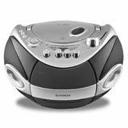
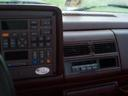
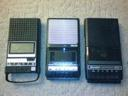
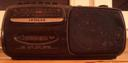
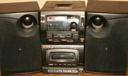

In [66]:
dp.head()

In [67]:
dp["planespot_slices"] = planespot.predict_proba(
    data=dp, scvis_embeddings = 'scvis', pred_probs = 'prob'
)

,img_path (PandasSeriesColumn),label (PandasSeriesColumn),label_id (PandasSeriesColumn),label_idx (PandasSeriesColumn),split (PandasSeriesColumn),img (ImageColumn),input (LambdaColumn),pred (NumpyArrayColumn),probs (NumpyArrayColumn),correct (NumpyArrayColumn),prob (NumpyArrayColumn),target (PandasSeriesColumn),embedding (NumpyArrayColumn),scvis (NumpyArrayColumn),planespot_slices (NumpyArrayColumn)
0,val/n02979186/n02979186_8971.JPEG,cassette player,n02979186,482,valid,,"tensor([[[2.2318, 2.2318, 2.2318, ..., 2.2318, 2.2318, 2.2318], [2.2318, 2.2318, 2.2318, ..., 2.2318, 2.2318, 2.2318], [2.2318, 2.2318, 2.2318, ..., 2.2318, 2.2318, 2.2318], ..., [2.2318, 2.2318, 2.2318, ..., 2.2318, 2.2318, 2.2318], [2.2318, 2.2318, 2.2318, ..., 2.2318, 2.2318, 2.2318], [2.2318, 2.2318, 2.2318, ..., 2.2318, 2.2318, 2.2318]], [[2.4111, 2.4111, 2.4111, ..., 2.4111, 2.4111, 2.4111], [2.4111, 2.4111, 2.4111, ..., 2.4111, 2.4111, 2.4111], [2.4111, 2.4111, 2.4111, ..., 2.4111, 2.4111, 2.4111], ..., [2.4111, 2.4111, 2.4111, ..., 2.4111, 2.4111, 2.4111], [2.4111, 2.4111, 2.4111, ..., 2.4111, 2.4111, 2.4111], [2.4111, 2.4111, 2.4111, ..., 2.4111, 2.4111, 2.4111]], [[2.6226, 2.6226, 2.6226, ..., 2.6226, 2.6226, 2.6226], [2.6226, 2.6226, 2.6226, ..., 2.6226, 2.6226, 2.6226], [2.6226, 2.6226, 2.6226, ..., 2.6226, 2.6226, 2.6226], ..., [2.6226, 2.6226, 2.6226, ..., 2.6226, 2.6226, 2.6226], [2.6226, 2.6226, 2.6226, ..., 2.6226, 2.6226, 2.6226], [2.6226, 2.6226, 2.6226, ..., 2.6226, 2.6226, 2.6226]]])",482,"np.ndarray(shape=(1000,))",True,3.824188e-07,False,"np.ndarray(shape=(512, 1, 1))","np.ndarray(shape=(2,))","np.ndarray(shape=(19,))"
1,val/n02979186/n02979186_14550.JPEG,cassette player,n02979186,482,valid,,"tensor([[[-1.3987, -1.3987, -1.3987, ..., 0.5193, 0.5193, 0.4508], [-1.3815, -1.3815, -1.3815, ..., 0.5878, 0.5878, 0.5364], [-1.3302, -1.3302, -1.3302, ..., 0.7933, 0.8104, 0.7762], ..., [-1.9124, -1.8953, -1.8953, ..., -1.5870, -1.5870, -1.6213], [-1.8953, -1.8782, -1.8782, ..., -1.6042, -1.6042, -1.6213], [-1.8953, -1.8782, -1.8782, ..., -1.6384, -1.6384, -1.6213]], [[-1.3529, -1.3529, -1.3529, ..., 1.2031, 1.2031, 1.1681], [-1.3880, -1.3880, -1.3880, ..., 1.2731, 1.2906, 1.2556], [-1.3880, -1.3880, -1.3880, ..., 1.4832, 1.5182, 1.5007], ..., [-2.0007, -1.9832, -1.9832, ..., -1.7206, -1.7206, -1.7381], [-1.9832, -1.9657, -1.9657, ..., -1.7731, -1.7731, -1.7731], [-1.9832, -1.9657, -1.9657, ..., -1.8431, -1.8431, -1.8081]], [[-1.1073, -1.1073, -1.1073, ..., 1.1585, 1.1237, 1.0191], [-1.1421, -1.1421, -1.1421, ..., 1.1934, 1.1759, 1.0714], [-1.1421, -1.1421, -1.1421, ..., 1.3851, 1.3851, 1.2805], ..., [-1.7522, -1.7347, -1.7347, ..., -1.3687, -1.3861, -1.4210], [-1.7347, -1.7173, -1.7173, ..., -1.4384, -1.4384, -1.4559], [-1.7347, -1.7173, -1.7173, ..., -1.5081, -1.5081, -1.4907]]])",754,"np.ndarray(shape=(1000,))",False,1.313724e-03,False,"np.ndarray(shape=(512, 1, 1))","np.ndarray(shape=(2,))","np.ndarray(shape=(19,))"
2,val/n02979186/n02979186_11971.JPEG,cassette player,n02979186,482,valid,,"tensor([[[1.2385, 1.3584, 1.3755, ..., 0.6392, 0.6049, 0.6906], [1.1529, 1.2557, 1.3070, ..., 0.6221, 0.6221, 0.7591], [1.0673, 1.1529, 1.2214, ..., 0.6392, 0.6392, 0.8104], ..., [0.5536, 0.6221, 0.6734, ..., 0.4166, 0.4166, 0.4337], [0.5364, 0.6392, 0.7077, ..., 0.3994, 0.3823, 0.3823], [0.5536, 0.6734, 0.7591, ..., 0.3652, 0.3309, 0.3309]], [[1.3081, 1.4307, 1.4482, ..., 0.7829, 0.7304, 0.7829], [1.2206, 1.3256, 1.3782, ..., 0.7829, 0.7654, 0.8529], [1.1331, 1.2206, 1.2906, ..., 0.8004, 0.8004, 0.9230], ..., [0.9230, 0.9930, 1.0455, ..., 0.7654, 0.7654, 0.7829], [0.8880, 0.9755, 1.0630, ..., 0.7129, 0.7129, 0.7304], [0.8704, 0.9930, 1.0805, ..., 0.6604, 0.6429, 0.6779]], [[1.0017, 1.1237, 1.1411, ..., 0.7925, 0.7402, 0.7576], [0.9145, 1.0191, 1.0714, ..., 0.7751, 0.7576, 0.8274], [0.8274, 0.9145, 0.9842, ..., 0.7925, 0.7925, 0.8797], ..., [1.2980, 1.3677, 1.4200, ..., 1.2631, 1.2631, 1.2457], [1.2631, 1.3502, 1.4374, ..., 1.2282, 1.2108, 1.1934], [1.2457,
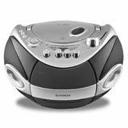
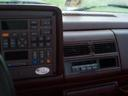
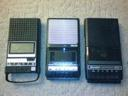
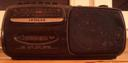
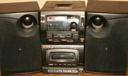
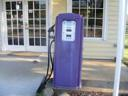
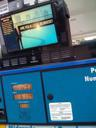
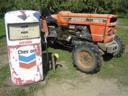
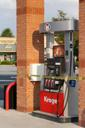
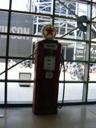